In [ ]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from LDR_dim import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
from functools import partial
import matplotlib.pyplot as plt

In [ ]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 5
macro_configs = config_generator()

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
### --- Set empirical parameters --- ###

#network properties size
N = 2000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
g = 4
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

In [4]:
#Set tasks

R = 2
alpha = 0.8
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
sigma_mn_all = np.zeros((R, R, N_tasks))
for i_task in range(N_tasks):
    sigma_mn_all[:,:,i_task] = generate_positive_definite_covariance(R=R, sigma_on=0.4,
                                                                     sigma_off=0.4,
                                                                     symmetry_factor=0)
sigma_mn_all[:,:,0] = np.array([[0.8, -0.4],
                                [0.4, 0.8]])
#sigma_mn_all[:,:,1] = np.array([[0.4, 0.8],
#                                [-0.8, 0.4]])
#sigma_mn_all[:,:,2] = np.array([[0.9, 0],
#                                [0, 0.9]])

In [5]:
D_changed = D.copy()
D_factor = 1
D_changed[0] *= D_factor
W_, all_loadings = sample_W_optimized(sigma_mn_all[:,:,:N_tasks], D_changed, N)

In [ ]:
x, r = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=100, noise_sigma=0)

In [22]:
T = 1000
dt = 0.05
n_T = int(T/dt)
#noise_coeffs = 10*np.random.normal(0, 1, (n_T, 2))
noise_coeffs = 0*np.ones((n_T, 2))
noise_series = np.einsum('in, tn -> it', all_loadings[0,:,0:2], noise_coeffs)
noise_series = noise_series[np.newaxis,:,:]
noise_series = torch.from_numpy(noise_series).to(0)
x0 = torch.tensor(200*D_changed[0]*all_loadings[0,:,2]).to(0).reshape((1, -1))
x, r = sample_activity(T_sim=1000, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_sigma=0, noise_series=noise_series)

In [ ]:
noise_series[:,:,10].shape

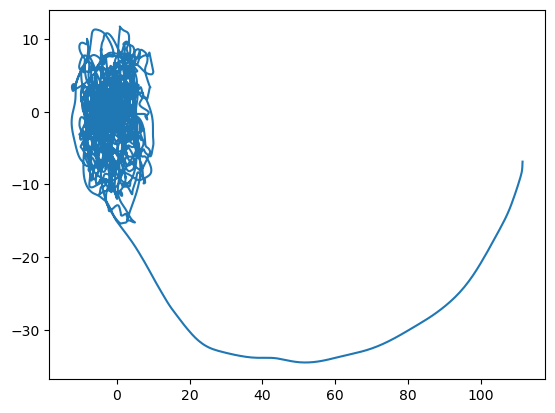

In [23]:
Z = np.einsum('air, ti -> atr', all_loadings[:9, :, 2:4], r) * D_changed[:9,None,None]
plt.plot(Z[0,:,0], Z[0,:,1])

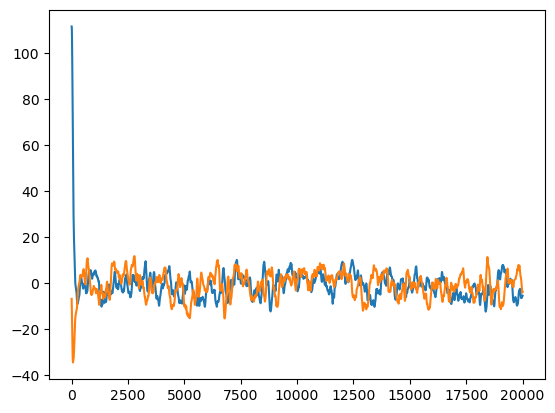

In [24]:
plt.plot(Z[0,:,0])
plt.plot(Z[0,:,1])

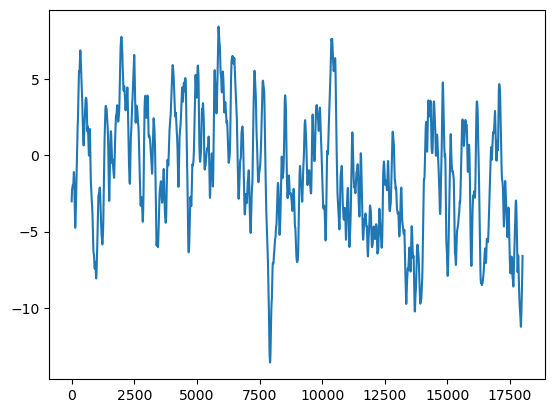

In [8]:
plt.plot(x[:,0])

In [ ]:
import numpy as np

def form_hankel(Y, i):
    """
    Create the block Hankel matrix with i rows-blocks (each block is N-dimensional),
    where Y has shape (N, T).
    The result is an (i*N) x (T-i+1) matrix.
    """
    N, T = Y.shape
    Hf = []
    for row_block in range(i):
        block = Y[:, row_block:(T - i + row_block + 1)]
        Hf.append(block)
    return np.vstack(Hf)  # shape (i*N, T-i+1)

def subspace_identification_moesp(Y, d, i=None):
    """
    Basic MOESP subspace ID for output-only data (no inputs).
    
    Parameters:
    -----------
    Y : np.ndarray, shape (T, N)
        Time series data (we'll transpose internally to (N, T)).
    d : int
        Desired rank / state dimension.
    i : int
        Number of 'block rows' to use in the Hankel matrix. Typically i >= d.

    Returns:
    --------
    A_est : (d, d)
    C_est : (N, d)
    X_est : (d, T)  # state estimates
    """

    # Usually we want Y to be shape (N, T).
    # If Y is (T, N), transpose it:
    if Y.shape[0] > Y.shape[1]:
        Y = Y.T  # now shape (N, T)
    N, T = Y.shape

    if i is None:
        # A common heuristic is i = 2*d or 3*d
        i = 2*d  

    # 1) Form block Hankel of i rows
    Hf = form_hankel(Y, i)  # shape (i*N, T-i+1)

    # 2) SVD
    U, s, Vt = np.linalg.svd(Hf, full_matrices=False)
    # Keep top d singular values
    U_d = U[:, :d]  # shape (i*N, d)
    S_d = np.diag(s[:d])
    V_d = Vt[:d, :]

    # 3) Partition U_d into two parts
    # top block: (i-1)*N rows
    # bottom block: N rows
    U_d1 = U_d[: (i-1)*N, :]  # shape ((i-1)*N, d)
    U_d2 = U_d[(i-1)*N :, :]  # shape (N, d)

    # 4) Estimate C
    # The simplest approach is to take the bottom block for C
    C_est = U_d2

    # 5) Estimate states (X) for each time k
    # We can define the "extended observability" matrix O_i = [C; C A; C A^2; ... C A^(i-1)]
    # But we skip that and do a simpler approach:
    # We know U_d1 ~ O_i * X_future, but let's skip the full detail and do a naive approach:
    # We'll define the 'states' at each shift as X_k = row k of (some factor).
    # A simpler method:
    #    The states in subspace ID can be reconstructed from the product:
    #    X_est_big = S_d * V_d
    # Then the first d rows/columns correspond to the subspace. 
    # We'll do a standard approach:

    # "Projected data" = U_d^T * Hf. 
    # Then the first row-block of that are the states, etc.
    # For MOESP, a simpler approach is that the row space of V_d = states over time, up to a transform.
    X_est_big = S_d @ V_d  # shape (d, T-i+1)
    
    # The columns of X_est_big are "the states" at times i..T. 
    # We'll define X_est to have length T, ignoring the first (i-1) uncertain steps:
    X_est = np.zeros((d, T))
    X_est[:, i-1:] = X_est_big  # or do some shifting if needed

    # 6) Estimate A by regressing X_{k+1} on X_k
    # We'll ignore the first index or so
    X_k = X_est[:, i-1 : T-1]   # shape (d, T-i)
    X_kp1 = X_est[:, i : T]     # shape (d, T-i)

    # Solve A_est in least squares sense
    A_est = X_kp1 @ X_k.T @ np.linalg.inv(X_k @ X_k.T + 1e-9*np.eye(d))

    return A_est, C_est, X_est

def estimate_Q_R(Y, A, C, X_est):
    """
    Compute Q and R from the residuals:
       Q ~ cov(x_{t+1} - A x_t)
       R ~ cov(y_t - C x_t)
    Y is (T, N).
    X_est is (d, T).
    """
    if Y.shape[0] > Y.shape[1]:
        Y = Y.T  # shape (N, T)
    N, T = Y.shape
    d, T_ = X_est.shape
    assert T_ == T

    # Q
    X_k = X_est[:, :-1]
    X_kp1 = X_est[:, 1:]
    resid_x = X_kp1 - A @ X_k
    Q_est = np.cov(resid_x)

    # R
    resid_y = Y - C @ X_est
    R_est = np.cov(resid_y)

    return Q_est, R_est

# ------------------------------------------------------------------------
# Example usage (synthetic oscillator data):
# ------------------------------------------------------------------------
if __name__ == "__main__":
    np.random.seed(42)

    # Generate a discrete-time 2D oscillator (damped)
    T = 1000
    N = 4   # We'll pretend we measure 4-dimensional data
    d = 2

    theta = 0.2   # rad per step
    damping = 0.98
    A_true = damping * np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    Q_true = 0.01*np.eye(d)

    C_true = np.random.randn(N, d) * 0.5
    R_true = 0.05*np.eye(N)

    # Simulate
    X = np.zeros((d, T))
    Y = np.zeros((N, T))
    for t in range(1, T):
        X[:, t] = A_true @ X[:, t-1] + np.random.multivariate_normal(np.zeros(d), Q_true)
        Y[:, t] = C_true @ X[:, t] + np.random.multivariate_normal(np.zeros(N), R_true)

    # 1) Subspace ID
    i_block = 10  # "future window" must be >= d
    A_est, C_est, X_est = subspace_identification_moesp(Y.T, d, i=i_block)  
    # Y.T => shape (T,N), we transpose it inside the function if needed
    print(X_est.shape)
    
    # 2) Estimate Q, R from the residuals
    Q_est, R_est = estimate_Q_R(Y, A_est, C_est, X_est)
    
    print("Estimated A:\n", A_est)
    print("True A:\n", A_true)
    print("\nEstimated Q:\n", Q_est)
    print("True Q:\n", Q_true)
    print("\nEstimated C:\n", C_est)
    print("True C:\n", C_true)
    print("\nEstimated R:\n", R_est)
    print("True R:\n", R_true)


In [ ]:
for i in range(4):
    plt.plot(x[:5000,i])

In [ ]:
i_block = 10  # "future window" must be >= d
A_est, C_est, X_est = subspace_identification_moesp(x[:, :100], d, i=i_block)  
# Y.T => shape (T,N), we transpose it inside the function if needed
#print(X_est.shape)
# 2) Estimate Q, R from the residuals
Q_est, R_est = estimate_Q_R(x[:, :100].T, A_est, C_est, X_est)

In [ ]:
print("Estimated A:\n", A_est)
#print("True A:\n", A_true)
print("\nEstimated Q:\n", Q_est)
#print("True Q:\n", Q_true)
print("\nEstimated C:\n", C_est)
#print("True C:\n", C_true)
print("\nEstimated R:\n", R_est)
#print("True R:\n", R_true)

In [ ]:
!ls files/

In [ ]:
!pwd

In [ ]:
for i in range(10):
    plt.plot(x[:5000,i])

In [ ]:
Z = np.einsum('air, ti -> atr', all_loadings[:9, :, 2:4], r) * D_changed[:9,None,None]
plt.plot(Z[0,:,0], Z[0,:,1])

In [ ]:
plt.plot(Z[0,:,0], Z[0,:,1])

In [ ]:
# ----------------------------------------
#  Example usage with synthetic data
# ----------------------------------------
if __name__ == "__main__":
    np.random.seed(42)
    T = 10000
    N = 2
    d = 2
    
    # True parameters
    A_true = np.array([[0.9, 0.0],
                       [0.1, 0.8]])
    Q_true = 0.1 * np.eye(d)
    C_true = np.array([[1.0, 0.0],
                       [0.0, 1.0]])
    R_true = 0.05 * np.eye(N)
    
    # Generate data
    x = np.zeros((T, d))
    y = np.zeros((T, N))
    for t in range(T):
        if t > 0:
            x[t] = A_true @ x[t-1] + np.random.multivariate_normal(np.zeros(d), Q_true)
        y[t] = C_true @ x[t] + np.random.multivariate_normal(np.zeros(N), R_true)
    
    # Fit
    A_est, Q_est, C_est, R_est, x_smooth, V_smooth, ll_history = em_lds(y, d, max_iter=50, tol=1e-4, verbose=True)
    
    print("\nEstimated A:\n", A_est)
    print("Estimated Q:\n", Q_est)
    print("Estimated C:\n", C_est)
    print("Estimated R:\n", R_est)

In [ ]:
R_true

In [ ]:
#W = np.random.normal(0, 1, (2000, 2000))
W = W_.cpu().numpy()
#W = W + W.T
eigs, vecs = np.linalg.eig(W)

In [ ]:
O = np.conj(vecs.T).dot(vecs)
off_diags = O[np.where(~np.eye(O.shape[0], dtype=bool))]

In [ ]:
np.mean(np.abs(off_diags)**2)

In [ ]:
plt.imshow(np.abs(np.conj(vecs.T).dot(vecs)[:30,:30]))
plt.colorbar()

In [ ]:
eigs = np.linalg.eigvals(W_.cpu().numpy())

In [ ]:
plt.plot(eigs.real, eigs.imag, '.')

In [ ]:
D_changed = D.copy()
D_factor = 1
D_changed[0] *= D_factor
#D_changed[1] *= D_factor*2
#D_changed[2] *= D_factor*0.5
#D_changed[2:] *= 0.5

W_, all_loadings = sample_W_optimized(sigma_mn_all[:,:,:N_tasks], D_changed, N)
N_loops = 3
z_acov_avg = 0
r_acov_avg = 0
x, r = sample_activity(T_sim=200, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=100, noise_sigma=0)
i_task = 0
x0 = torch.tensor(x[0] + 200*D_changed[i_task]*all_loadings[i_task,:,2]).to(0).reshape((1, -1))
x, r = sample_activity(T_sim=100, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch, x0=x0,
                       runga_kutta=True, T_save_delay=0, noise_sigma=0)

In [ ]:
Z = np.einsum('air, ti -> atr', all_loadings[:9, :, 2:4], r) * D_changed[:9,None,None]

In [ ]:
plt.plot(Z[i_task,:,0], Z[i_task,:,1])

In [ ]:
plt.plot(Z[0,:,0])
plt.plot(Z[0,:,1])
plt.plot(Z[1,:,0])
plt.plot(Z[1,:,1])

In [ ]:
Zs = []
fig, ax = plt.subplots(6, 1, figsize=(2, 10))
for i_alpha, alpha in enumerate([0.02, 0.05, 0.1, 0.2, 0.4, 0.8]):
    R = 2
    N_tasks = int(alpha * N)
    PR_D = 1
    if PR_D < 1:
        beta_D = invert_PR_by_newton(PR_D)
        D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
    else:
        D = np.ones(N_tasks)
    g_correction = g / np.sqrt(np.sum(D**2)*R/N)
    D = D * g_correction
    sigma_mn_all = np.zeros((R, R, N_tasks))
    for i_task in range(N_tasks):
        sigma_mn_all[:,:,i_task] = generate_positive_definite_covariance(R=R, sigma_on=0.6,
                                                                         sigma_off=0.6,
                                                                         symmetry_factor=0)
    sigma_mn_all[:,:,0] = np.array([[0.8, -0.4],
                                    [0.4, 0.8]])
    
    D_changed = D.copy()

    W_, all_loadings = sample_W_optimized(sigma_mn_all[:,:,:N_tasks], D_changed, N)
    i_task = 0
    x, r_pre = sample_activity(T_sim=200, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=100, noise_sigma=0)
    n_task = all_loadings[i_task,:,2]
    n_task = n_task / np.linalg.norm(n_task)
    x0 = torch.tensor(x[0] + N*n_task).to(0).reshape((1, -1))
    x, r = sample_activity(T_sim=100, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=True, T_save_delay=0, noise_sigma=0)
    r = np.concatenate([r_pre, r])
    #Z = np.einsum('air, ti -> atr', all_loadings[:9, :, 2:4], r) * D_changed[:9,None,None]
    Z = np.einsum('air, ti -> atr', all_loadings[:9, :, 2:4], r)
    Zs.append(Z)
    ax[i_alpha].plot(Z[0,1000:3000,0], color='#986FB0')
    ax[i_alpha].plot(Z[0,1000:3000,1], color='#986FB0')
    ax[i_alpha].plot(Z[1,1000:3000,0], color='#E9216C')
    ax[i_alpha].plot(Z[1,1000:3000,1], color='#E9216C')
    ax[i_alpha].set_ylim([-700, 700])

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(9, 6))
alphas = [0.02, 0.05, 0.1, 0.2, 0.4, 0.8]
ax = ax.flatten()
time_vec = np.arange(0, 100, 0.05)
for i_alpha in range(6):
    Z = Zs[5-i_alpha]
    ax[i_alpha].plot(time_vec, Z[1,1000:3000,0], color='#E9216C')
    ax[i_alpha].plot(time_vec, Z[1,1000:3000,1], color='#E9216C')
    ax[i_alpha].plot(time_vec, Z[0,1000:3000,0], color='#986FB0')
    ax[i_alpha].plot(time_vec, Z[0,1000:3000,1], color='#986FB0')
    ax[i_alpha].set_title(r'$\alpha = {}$'.format(alphas[5-i_alpha]))
    #ax[i_alpha].set_ylim([-1000, 1000])

In [ ]:
Z = Zs[3]
plt.plot(time_vec, Z[1,1000:3000,0], color='#E9216C')
plt.plot(time_vec, Z[1,1000:3000,1], color='#E9216C')
plt.plot(time_vec, Z[0,1000:3000,0], color='#986FB0')
plt.plot(time_vec, Z[0,1000:3000,1], color='#986FB0')

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'double_Crr'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='misc')

In [ ]:
Zs = []
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()
for i_SR, SR in enumerate([0.9, 1.2, 2]):
    R = 2
    alpha=0.8
    N_tasks = int(alpha * N)
    PR_D = 1
    if PR_D < 1:
        beta_D = invert_PR_by_newton(PR_D)
        D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
    else:
        D = np.ones(N_tasks)
    g_correction = g / np.sqrt(np.sum(D**2)*R/N)
    D = D * g_correction
    sigma_mn_all = np.zeros((R, R, N_tasks))
#     for i_task in range(N_tasks):
#         sigma_mn_all[:,:,i_task] = generate_positive_definite_covariance(R=R, sigma_on=0.6,
#                                                                          sigma_off=0.6,
#                                                                          symmetry_factor=0)
#     sigma_mn_all[:,:,0] = np.array([[0.8, -0.4],
#                                     [0.4, 0.8]])
    sigma_mn_all = theory_results[3]['0.8_8_0']
    
    D_changed = D.copy()
    D_factor = SR/0.566
    D_changed[0] *= D_factor
    
    W_, all_loadings = sample_W_optimized(sigma_mn_all[:,:,:N_tasks], D, N)
    i_task = 0
    x, r_pre = sample_activity(T_sim=200, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=100, noise_sigma=0)
    n_task = all_loadings[i_task,:,2]
    n_task = n_task / np.linalg.norm(n_task)
    x0 = torch.tensor(x[-1]).to(0).reshape((1, -1))
    W_, all_loadings = sample_W_optimized(sigma_mn_all[:,:,:N_tasks], D_changed, N)
    x, r = sample_activity(T_sim=100, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch, x0=x0,
                           runga_kutta=True, T_save_delay=0, noise_sigma=0)
    r = np.concatenate([r_pre, r])
    #Z = np.einsum('air, ti -> atr', all_loadings[:9, :, 2:4], r) * D_changed[:9,None,None]
    Z = np.einsum('air, ti -> atr', all_loadings[:9, :, 2:4], r)
    Zs.append(Z)
    D_norm = np.ones((3, 4000))
    D_norm[:3,:2000] = D[:3][:,None]
    D_norm[:3,2000:] = D_changed[:3][:,None]
    ax[i_SR].plot(Z[1,:,0]/D_norm[1], color='#5FC6C3')
    ax[i_SR].plot(Z[1,:,1]/D_norm[1], color='#5FC6C3')
    ax[i_SR].plot(Z[2,:,0]/D_norm[2], color='#E9216C')
    ax[i_SR].plot(Z[2,:,1]/D_norm[2], color='#E9216C')
    ax[i_SR].plot(Z[0,:,0]/D_norm[0], color='#986FB0')
    ax[i_SR].plot(Z[0,:,1]/D_norm[0], color='#986FB0')
    #ax[i_SR].set_ylim([-700, 700])

In [ ]:
6.32455532 / 0.566 * 2

In [ ]:

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
Ds = [10.1, 13.4, 22.3]
ax = ax.flatten()
time_vec = np.arange(-100, 100, 0.05)
for i_SR in range(3):
    Z = Zs[i_SR]
    ax[i_SR].plot(time_vec, Z[1,:,0]/D_norm[1], color='#5FC6C3')
    ax[i_SR].plot(time_vec, Z[1,:,1]/D_norm[1], color='#5FC6C3')
    ax[i_SR].plot(time_vec, Z[2,:,0]/D_norm[2], color='#E9216C')
    ax[i_SR].plot(time_vec, Z[2,:,1]/D_norm[2], color='#E9216C')
    ax[i_SR].plot(time_vec, Z[0,:,0]/D_norm[0], color='#986FB0')
    ax[i_SR].plot(time_vec, Z[0,:,1]/D_norm[0], color='#986FB0')
    ax[i_SR].set_ylim([-2.2, 2.2])
    ax[i_SR].set_xlim([-40, 100])
    ax[i_SR].set_title(r'$D_1 = {}$'.format(Ds[i_SR]))
    ax[i_SR].set_xlabel('time')
    ax[i_SR].axvline(x=0, color='k', linestyle='--')

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(9, 6))
alphas = [0.02, 0.05, 0.1, 0.2, 0.4, 0.8]
ax = ax.flatten()
Ds = [10.1, 13.4, 22.3]
time_vec = np.arange(0, 100, 0.05)
for i_alpha in range(5):
    Z = Zs[4-i_alpha]
    ax[i_alpha].plot(time_vec, Z[1,1000:3000,0], color='#E9216C')
    ax[i_alpha].plot(time_vec, Z[1,1000:3000,1], color='#E9216C')
    ax[i_alpha].plot(time_vec, Z[0,1000:3000,0], color='#986FB0')
    ax[i_alpha].plot(time_vec, Z[0,1000:3000,1], color='#986FB0')
    ax[i_alpha].set_title(r'$\alpha = {}$'.format(alphas[5-i_alpha]))
    #ax[i_alpha].set_ylim([-1000, 1000])

In [ ]:
N_loops = 3
z_ccov_avg = 0
for i_loop in range(N_loops):
    x, r = sample_activity(T_sim=2100, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=100, noise_sigma=0)
    Z = np.einsum('air, ti -> atr', all_loadings[:9, :, 2:4], r) * D_changed[:9,None,None]
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[:,:,:], axis=1, norm='ortho'))**2, axis=1)
    r_acov = np.fft.irfft(np.mean(np.abs(np.fft.rfft(r, axis=0, norm='ortho'))**2, axis=1), axis=0)
    fft_0 = np.fft.rfft(Z[3,:,0], axis=0, norm='ortho')
    fft_1 = np.fft.rfft(Z[3,:,1], axis=0, norm='ortho')
    z_ccov = np.fft.irfft(np.conj(fft_0)*fft_1)
    z_ccov_avg += z_ccov/N_loops
    z_acov_avg += z_acov/N_loops
    r_acov_avg += r_acov/N_loops

In [ ]:
plt.plot(z_ccov_avg[:800])
plt.plot(z_acov_avg[3,:800,0])
plt.plot(z_acov_avg[3,:800,1])

In [ ]:
eigs = np.linalg.eigvals(W_.cpu().numpy())
plt.plot(eigs.real, eigs.imag, '.')

In [ ]:
freq = np.fft.fftfreq(Z[:2,:,0].shape[1], 0.05) * 2 * np.pi
plt.plot(freq, np.abs(np.fft.fft(Z[:2,:,0], axis=1).T))
plt.xlim([0,2.5])

In [ ]:
Z[:2,:,2].shape

In [ ]:
for i_task in range(2):
    plt.plot(Z[i_task,:,0], Z[i_task,:,1])

In [ ]:
plt.plot(Z[0,:4000,0]/np.amax(Z[0,:2000,0]))
plt.plot(Z[1,:4000,0]/np.amax(Z[1,:2000,0]))

In [ ]:
for i_task in range(3):
    plt.plot(z_acov_avg[i_task, :4000, 0]/z_acov_avg[i_task, 0, 0])
plt.plot(r_acov_avg[:4000]/r_acov_avg[0])

In [ ]:
plt.plot(r_acov_avg[:1000])

In [ ]:
1/((0.4/0.8)/(0.7/0.5))

In [ ]:
N_W_samples = 10
C_emp_avg = 0
S_emp_avg = 0

#lags window
dt = 0.05
T_window_emp = 120
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)

for i_W_sample in range(N_W_samples):
    
    W_, all_loadings = sample_W_optimized(sigma_mn_all, D, N)
    
    ### --- Estimate C empirically --- ###
    
    x, r = sample_activity(T_sim=10000, dt_save=dt, dt=dt, W=W_, phi_torch=phi_torch,
                           runga_kutta=True, T_save_delay=200)
    r = torch.from_numpy(r).type(torch.FloatTensor).to(0)
    eta = torch.matmul(r, W_.T)
    phi_ft = uni_rfft(r.T, dt, dim=1)
    eta_ft = uni_rfft(eta.T, dt, dim=1)
    C_eta_ft = uni_corr(eta_ft, eta_ft, dt, dim=1).mean(0)
    C_phi_eta_ft = uni_corr(phi_ft, eta_ft, dt, dim=1).mean(0)
    C_eta_ft[C_eta_ft == 0] = np.nan
    S_ft = uni_conv(C_phi_eta_ft, uni_inv(C_eta_ft))
    S_ft[torch.isnan(S_ft)] = 0.0
    S = uni_irfft(S_ft, dt)
    S_emp = S.cpu().numpy()
    C_emp_unit = compute_lagged_xcov(r[:,None,:], r[:,None,:], lags_emp, dt_save=dt)
    C_emp = C_emp_unit.cpu().detach().numpy().squeeze().mean(-1)
    C_emp = upsample_array(C_emp, int(dT_emp/dt))
    C_emp = np.concatenate([C_emp, np.array([C_emp[-1]]), C_emp[1:][::-1]])
    lags_emp_full = np.concatenate([lags_emp, np.array([lags_emp[-1]]), -lags_emp[1:][::-1]])
    
    C_emp_avg += C_emp / N_W_samples
    S_emp_avg += S_emp[:len(C_emp)] / N_W_samples

In [ ]:
x_cov, r_cov = estimate_cov_eigs(T_sim=2000, dt_save=1, dt=0.05, W=W_, phi_torch=phi_torch,
                                 T_save_delay=1000, N_batch=1, N_loops=25,
                                 return_raw_covs=True, runga_kutta=True)

dim_emp = np.trace(r_cov)**2 / (r_cov**2).sum() / N

In [ ]:
### --- Set theory parameters --- ###
T_window = 120
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([lags, np.array([lags[-1]]), -lags[1:][::-1]])

In [ ]:
sigma_mn_all_flat = np.vstack(sigma_mn_all)
N_samples = 10000
num_iter = 400
final_avg_iter = 50
#run DMFT solver loop
C_dmft, S_dmft = util.solve_dmft(
    update_fn=(lambda C, S:
               update_extensive_tasks_2x2(torch.tensor(D).to(0),
                                          torch.tensor(sigma_mn_all_flat).to(0),
                                          C, S, N_samples=N_samples,
                                          dt=dT, alpha=params['alpha'])),
    callback_fn=None,
    init_dt=dT,
    N_t=int((2*T_window)/dT),
    num_iter=num_iter,
    device=0,
    alpha=0.8,
    final_avg_iter=final_avg_iter)

In [ ]:
C_numpy = C_dmft.cpu().detach().numpy()
S_numpy = S_dmft.cpu().detach().numpy()

In [ ]:
processed_data = np.array([S_numpy, S_emp_avg, C_numpy, C_emp_avg])

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sigma_mn_all, 'dim_emp': dim_emp,
          'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [ ]:
###Truncate file above
file_name = 'extensive_tasks_dim'
job_name = 'g_alpha_explore'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

In [ ]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=64, n_hours=24, n_gpus=1,
               results_subdir='PRL_Submission')
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False,
           results_subdir='PRL_Submission', lkumar=False)

In [ ]:
###Get job status
get_ipython().system('squeue -u om2382')

In [ ]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'g_alpha_explore'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
theory_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [ ]:
job_name = 'LDR_sym_PR_match_rho_sim_final_5'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
sim_results = unpack_processed_data(job_script_path, results_subdir='PRL_Submission')

In [ ]:
theory_results[3].keys()

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 10, figsize=(20, 10))
#i_seed = 2
for i in range(5):
    for j in range(10):
        for i_seed in range(5):
            ax[i,j].plot(theory_results[1][i,j,i_seed,0,:200], color='C0', linewidth=2)
            ax[i,j].plot(theory_results[1][i,j,i_seed,1,:200], color='C1')
            #ax[i,j].plot(theory_results[1][i,j,0,0,:600], color='C0')
            #ax[i,j].plot(theory_results[1][i,j,0,1,:600], color='C1')
            ax[i,j].set_ylim([0, 0.5])

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 10, figsize=(20, 10))
for i in range(5):
    for j in range(10):
        for i_seed in range(5):
            ax[i,j].plot(theory_results[1][i,j,i_seed,2,:800], color='C0', linewidth=2)
            ax[i,j].plot(theory_results[1][i,j,i_seed,3,:800], color='C1')
            ax[i,j].set_ylim([-0.1, 1.1])

In [ ]:
theory_results[0]

In [ ]:
for i_seed in range(5):
    plt.plot(dim_tensor[:,5,i_seed], '.', color='C0')

In [ ]:
dim_tensor = np.zeros([len(v) for v in theory_results[0].values()])
for i_alpha, alpha in enumerate(theory_results[0]['alpha']):
    for i_g, g in enumerate(theory_results[0]['g']):
        for i_seed in range(5):
            i_job = reverse_index_config((alpha, g, i_seed), theory_results[0])
            save_dir = os.path.join(project_dir, 'results', 'PRL_Submission', job_name)
            result_path = os.path.join(save_dir, 'result_{}'.format(i_job))
            try:
                with open(result_path, 'rb') as f:
                    data = pickle.load(f)
                    dim_tensor[i_alpha, i_g, i_seed] = data['dim_emp']
            except FileNotFoundError:
                dim_tensor[i_alpha, i_g, i_seed] = np.nan
                print((alpha, g, i_seed))

In [ ]:
dim_tensor = np.zeros([len(v) for v in theory_results[0].values()])
for i_sigma, sigma in enumerate(theory_results[0]['sigma']):
    for i_alpha, alpha in enumerate(theory_results[0]['alpha']):
        for i_g, g in enumerate(theory_results[0]['g']):
            for i_seed in range(5):
                i_job = reverse_index_config((sigma, alpha, g, i_seed), theory_results[0])
                save_dir = os.path.join(project_dir, 'results', 'PRL_Submission', job_name)
                result_path = os.path.join(save_dir, 'result_{}'.format(i_job))
                try:
                    with open(result_path, 'rb') as f:
                        data = pickle.load(f)
                        dim_tensor[i_sigma, i_alpha, i_g, i_seed] = data['dim_emp']
                except FileNotFoundError:
                    dim_tensor[i_sigma, i_alpha, i_g, i_seed] = np.nan
                    print((sigma, alpha, g, i_seed))

In [ ]:
leg = []
for i in range(2):
    for j in range(3):
        #for k in range(5):
            plt.plot(np.nanmean(dim_tensor, axis=-1)[i,j,:])
            #plt.plot(dim_tensor[i,j,:,k], '.', color='C{}'.format(2*i + j))
            leg.append('sigma = {}, alpha = {}'.format(theory_results[0]['sigma'][i],
                                                       theory_results[0]['alpha'][j]))
plt.legend(leg)

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(4, 3, figsize=(8, 10))
for i in range(4):
    for j in range(3):
        ax[i,j].plot(theory_results[1][0,j,i,0,1,:600], color='C0')
        ax[i,j].plot(theory_results[1][0,j,i,0,2,:600], color='C1')
        ax[i,j].plot(theory_results[1][1,j,i,0,1,:600], color='C0')
        ax[i,j].plot(theory_results[1][1,j,i,0,2,:600], color='C1')
        ax[i,j].set_ylim([0, 1])

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(4, 3, figsize=(8, 10))
for i in range(4):
    for j in range(3):
        ax[i,j].plot(theory_results[1][0,j,i,0,0,:1000], color='C0')
        ax[i,j].plot(theory_results[1][1,j,i,0,0,:1000], color='C1')
        ax[i,j].set_ylim([-0.5, 1])

In [ ]:
theory_results[0]

In [ ]:
smn_all = theory_results[3]['0.8_20_2']
smn_all_changed = smn_all.copy()
smn_all_changed[:,:,0] = np.array([[0.4, -0.2], [0.2, 0.4]])
S = torch.tensor(theory_results[1][2,9,2,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][2,9,2,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 5000
R = 2
alpha = 0.8
g = 20
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all_changed[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 0.5 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all_changed, D, N)
W_changed, all_loadings_changed = sample_W_optimized(smn_all_changed, D_changed, N)
x1, r1 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200)
#I_current = 100*torch.from_numpy(0.5*all_loadings_changed[0,:,0] + 0.5*all_loadings_changed[0,:,1]).to(0)
x2, r2 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0),
                        input_current=None)
x = np.vstack([x1, x2])
r = np.vstack([r1, r2])
Z_changed = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r2) * D_changed[:5,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_changed[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])

In [ ]:
r_acov = np.fft.irfft(np.abs(np.fft.rfft(r2, axis=0, norm='ortho'))**2, axis=0).mean(1)

In [ ]:
plt.plot(Z_changed[0,:,0])

In [ ]:
plt.plot(r_acov[:2000])

In [ ]:
r2_ss = r2[::20,:]

In [ ]:
r2_cov = np.einsum('ti, tj -> ij', r2_ss, r2_ss)/(r2_ss.shape[0] - 1)

In [ ]:
eigs, vecs = np.linalg.eig(r2_cov)

In [ ]:
proj = r2[2000:23000].dot(vecs[:,:4])
plt.plot(proj[:,0], proj[:,1])

In [ ]:
proj_m = r2[6000:23000].dot(np.linalg.pinv(all_loadings_changed[0,:,:2].T))
proj_m_2 = r2[6000:23000].dot(all_loadings_changed[0,:,:2])
plt.plot(proj_m[:,0], proj_m[:,1])
plt.plot(proj_m_2[:,0], proj_m_2[:,1])

In [ ]:
Ms = all_loadings_changed[0,:,:2].T

In [ ]:
PCs = vecs[:,:2]

In [ ]:
pc_m_proj = Ms.dot(PCs)/(np.sqrt(np.sum(Ms**2, 1))[:,None])

In [ ]:
# Function to project vector 'a' onto vector 'b'
def project(a, b):
    return np.dot(b.T, a) / np.dot(b.T, b) * b

# Orthogonalize the first set against the second set
def orthogonalize(vectors, basis):
    # Iterate over each vector in 'vectors' and subtract projection onto 'basis'
    orthogonal_vectors = np.zeros_like(vectors)
    for i in range(vectors.shape[1]):
        projection = np.zeros_like(vectors[:, i])
        for j in range(basis.shape[1]):
            projection += project(vectors[:, i], basis[:, j])
        orthogonal_vectors[:, i] = vectors[:, i] - projection
    return orthogonal_vectors

# Compute the orthogonal components of v relative to w
v_orthogonal = orthogonalize(PCs, Ms.T)

# Output the resulting orthogonal vectors
print(v_orthogonal)


In [ ]:
v_orth_unit = v_orthogonal / np.sqrt(np.sum(v_orthogonal**2, 0))[None, :]

In [ ]:
v_orth_unit

In [ ]:
eigs_W, vecs_W = np.linalg.eig(W_changed.cpu().numpy())

In [ ]:
proj_strength = np.square(np.abs(v_orth_unit.T.dot(vecs_W[:,:])).sum(0))
plt.scatter(eigs_W.real, eigs_W.imag, alpha=np.sqrt(proj_strength/np.max(proj_strength)))

In [ ]:
# do mean field theory with replacing g^2 C term with stuff from mutually referential self consistent picture
# figure out mechanism for boosting tasks? can be subtle, phase transition

In [ ]:
for i_task in range(5):
    plt.plot(Z_changed[i_task, 20000:22000,1])

In [ ]:
for i_task in range(5):
    plt.plot(Z_changed[i_task, 22000:23000,1])

In [ ]:
smn_all = theory_results[3]['0.8_20_2']
smn_all_changed = smn_all.copy()
smn_all_changed[:,:,0] = np.array([[0.4, -0.2], [0.2, 0.4]])
S = torch.tensor(theory_results[1][2,9,2,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][2,9,2,2,:], dtype=torch.float32).to(0)
N_t = C.shape[0]
T_extra = 1000
dt = 0.05

N = 1000
R = 2
alpha = 0.8
g = 20
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction

SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all_changed[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt)
D_changed = D.copy()
D_factor = 1.5 / SR
D_changed[0] *= D_factor

W_, all_loadings = sample_W_optimized(smn_all_changed[:,:,:N_tasks], D, N)
W_changed, all_loadings_changed = sample_W_optimized(smn_all_changed[:,:,:N_tasks], D_changed, N)
x1, r1 = sample_activity(T_sim=500, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=200)
x2, r2 = sample_activity(T_sim=1000, dt_save=0.05, dt=0.05, W=W_changed, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=0, x0=torch.from_numpy(x1[-1][None,:]).to(0))
x = np.vstack([x1, x2])
r = np.vstack([r1, r2])
Z_changed = np.einsum('air, ti -> atr', all_loadings_changed[:5, :, 2:4], r) * D_changed[:5,None,None]

In [ ]:
plt.plot(Z_changed[0,:,0])

In [ ]:
plt.plot(Z_changed[0,:,0])
plt.plot(Z_changed_small_M[0,:,0])

In [ ]:
np.amax(Z_changed[0,:,0])/np.amax(Z_changed_small_M[0,:,0])

In [ ]:
_**2

In [ ]:
for i_task in range(5):
    plt.plot(Z_changed[i_task, 20000:21000,0])

In [ ]:
plt.plot(x[1000:3000,0])

In [ ]:
plt.plot(phi_prime_numpy(x).mean(-1)[20000:21000])
plt.plot(phi_prime_numpy(x).mean(-1)[:1000])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_changed[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * C
    #N_t_extra = int(T_extra/dt)
    #half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    #half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    #D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 10
    #N_t_total = D2Cphi_extended.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
[np.linalg.eigvals(smn_all[:,:,i_task]) for i_task in range(4)]

In [ ]:
D[0]

In [ ]:
SRs = [0.4, 0.405, 0.41, 0.415]
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
ax = ax.flatten()
for i_SR, SR in enumerate(SRs):
    D_changed = D.copy()
    D_factor = SR / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
    D_changed[0] *= D_factor
    D2Cphi = D_changed[i_task]**2 * C
    T_extra = 2000
    dt = 0.05
    N_t_extra = int(T_extra/dt)
    half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    sim_eta_z = sample_gp(D2Cphi_extended, 2*N_trials)
    sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
    Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
    ax[i_SR].plot(Z_sim[0], Z_sim[1])

In [ ]:
smn_all = theory_results[3]['0.8_20_2']
S = torch.tensor(theory_results[1][2,9,0,0,:], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][2,9,0,2,:], dtype=torch.float32).to(0)
N = 5000
R = 2
alpha = 0.8
g = 20
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
#W_, all_loadings = sample_W_optimized(smn_all, D, N)
#x, r = sample_activity(T_sim=10000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
#                       runga_kutta=True, T_save_delay=100)
#Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D[:10,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D[i_task]**2 * C
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 50
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
smn_all = theory_results[3]['0.5_1_1.4_0']
S = torch.tensor(theory_results[1][1,1,3,0,0], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,1,3,0,1], dtype=torch.float32).to(0)
N = 5000
R = 2
alpha = 1
g = 1.4
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D_changed = D.copy()
D_factor = 0.5 / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
D_changed[0] *= D_factor
W_, all_loadings = sample_W_optimized(smn_all, D_changed, N)
x, r = sample_activity(T_sim=12000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=500)
Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D_changed[:10,None,None]
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * C
    C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 80
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
#is it really the noise stability thing like chat gpt thinks or
#am i just not normalizing the fourier transform correctly?

In [ ]:
D_factor = 0.5 / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(torch.fft.rfft(S).cpu().numpy())[0])))

In [ ]:
np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.real(torch.fft.fft(S).cpu().numpy())[0])))

In [ ]:
smn_all = theory_results[3]['0.5_1_1.4_0']
S = torch.tensor(theory_results[1][1,1,3,0,0], dtype=torch.float32).to(0)
C =  torch.tensor(theory_results[1][1,1,3,0,1], dtype=torch.float32).to(0)
N = 5000
R = 2
alpha = 1
g = 1.4
N_tasks = int(alpha * N)
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
D_changed = D.copy()
D_factor = 0.3 / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
D_changed[0] *= D_factor
i_task = 0
W_, all_loadings = sample_W_optimized(smn_all, D_changed, N)

In [ ]:
plt.plot(torch.abs(uni_rfft(S, 0.05).cpu()))

In [ ]:
torch.fft.rfft(S)

In [ ]:
plt.plot(torch.real(torch.fft.rfft(S).cpu()))

In [ ]:
x, r = sample_activity(T_sim=12000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=500)
Z = np.einsum('air, ti -> atr', all_loadings[:5, :, 2:4], r) * D_changed[:5,None,None]

In [ ]:
D2Cphi = D_changed[i_task]**2 * C
C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
N_trials = 1
N_t = S.shape[0]
Z_sim_trials = np.zeros((N_trials, 2, N_t))
i_trial = 0
sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
plt.plot(Z_sim[0], Z_sim[1])

In [ ]:
plt.plot(D2Cphi.cpu())
T_extra = 1000
dt = 0.05
N_t_extra = int(T_extra/dt)

half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
plt.plot(D2Cphi_extended.cpu())

In [ ]:
SRs = [0.4, 0.405, 0.41, 0.415]
fig, ax = plt.subplots(2, 2, figsize=(8, 4))
ax = ax.flatten()
for i_SR, SR in enumerate(SRs):
    D_changed = D.copy()
    D_factor = SR / np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))
    D_changed[0] *= D_factor
    D2Cphi = D_changed[i_task]**2 * C
    T_extra = 2000
    dt = 0.05
    N_t_extra = int(T_extra/dt)
    half_D2CPhi = torch.tensor(fix(D2Cphi.cpu().numpy()[:N_t//2])).to(0)
    half_D2CPhi_2 = torch.tensor(fix(D2Cphi.cpu().numpy()[N_t//2:][::-1])[::-1].copy()).to(0)
    D2Cphi_extended = torch.cat([half_D2CPhi, torch.zeros(N_t_extra).to(0), half_D2CPhi_2])
    sim_eta_z = sample_gp(D2Cphi_extended, 2*N_trials)
    sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
    Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
    ax[i_SR].plot(Z_sim[0], Z_sim[1])

In [ ]:
np.abs(np.linalg.eigvals(D_changed[0]*smn_all[:,:,0]*torch.fft.rfft(S).cpu().numpy()[0]))

In [ ]:
np.abs(np.linalg.eigvals(D_changed[0]*smn_all[:,:,0]*torch.fft.rfft(S, norm='backward')[0].cpu().numpy()))*dt

In [ ]:
torch.fft.rfft(S, norm='backward')[0].cpu().numpy()

In [ ]:
np.linalg.eigvals(D_changed[0] * smn_all[:,:,0]) * S_w_max

In [ ]:
S_w_max

In [ ]:
SRs = [0.9, 0.95, 0.98, 1, 1.02, 1.05, 1.1]
fig, ax = plt.subplots(len(SRs), figsize=(2, 14))
S_w_max = np.abs(torch.fft.rfft(S, norm='backward').cpu().numpy())[0] * dt
original_SR = np.amax(np.abs(np.linalg.eigvals(D[0]*smn_all[:,:,0]*S_w_max)))
for i_SR, SR in enumerate(SRs):
    D_changed = D.copy()
    D_factor = SR / original_SR
    D_changed[0] *= D_factor
    i_task = 0
    W_, all_loadings = sample_W_optimized(smn_all, D_changed, N)
    eigs = np.linalg.eigvals(W_.cpu().numpy())
    ax[i_SR].plot(eigs.real, eigs.imag, '.')

In [ ]:
for error in [-0.2, 0.1, 0.05, 0.05, 0.1, 0.2]:
    print(np.linalg.eigvals((D_changed[0] + error)*smn_all[:,:,0]*uni_rfft(S, 0.05).cpu().numpy()[0]))

In [ ]:
eigs = np.linalg.eigvals(W_.cpu().numpy())
plt.plot(eigs.real, eigs.imag, '.')

In [ ]:
np.linalg.eigvals(D_changed[0]*smn_all[:,:,0] * np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])

In [ ]:
D[0]**2 * C[0]

In [ ]:
np.amax(np.abs(D_changed[0]*np.linalg.eigvals(smn_all[:,:,0]*np.abs(uni_rfft(S, 0.05).cpu().numpy())[0])))

In [ ]:
plt.plot(C.cpu().numpy())

In [ ]:
plt.plot(np.abs(uni_rfft(S, 0.05).cpu().numpy()))

In [ ]:
theory_results[1].shape
fig, ax = plt.subplots(5, 3, figsize=(8, 10))
for i in range(5):
    for j in range(3):
        ax[i,j].plot(theory_results[1][i,j,0,0,1,:600], color='C0')
        ax[i,j].plot(theory_results[1][i,j,0,0,2,:600], color='C1')
        ax[i,j].set_ylim([0, 1])

In [ ]:
smn_all = theory_results[3]['0.5_6_False_0']


In [ ]:
### --- Set empirical parameters --- ###

#network properties size
N = 5000
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
g = 6
#lags window
T_window_emp = 1
dT_emp = 1
lags_emp = np.arange(0, T_window_emp, dT_emp)
n_lags_emp = int(T_window_emp/dT_emp)
#Network size
R = 2
sigma_sigma = 0.5
N_tasks = 5000
alpha = N_tasks / N
PR_D = 1
if PR_D < 1:
    beta_D = invert_PR_by_newton(PR_D)
    D = np.exp(-beta_D*np.arange(N_tasks)/N_tasks)
else:
    D = np.ones(N_tasks)
g_correction = g / np.sqrt(np.sum(D**2)*R/N)
D = D * g_correction
def sample_W(sigma_mn_all, D, N):
    W = 0
    R = sigma_mn_all.shape[0]
    N_tasks = sigma_mn_all.shape[2]
    all_loadings = np.zeros((N_tasks, N, 2*R))
    for i_task in range(N_tasks):
        sigma_mm = np.eye(R)
        sigma_nn = np.eye(R)
        sigma_mn = sigma_mn_all[:,:,i_task]
        covariance_top = np.hstack([sigma_mm, sigma_mn])
        covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
        covariance = (1/N)*np.vstack([covariance_top, covariance_bot])

        loadings = np.random.multivariate_normal(np.zeros(2*R), covariance, size=N)
        all_loadings[i_task] = loadings
        W_task = D[i_task]*np.einsum('ir, jr -> ij', loadings[:,:R], loadings[:,R:])
        W += W_task
    W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
    
    return W_, all_loadings

#W_, all_loadings = sample_W(smn_all*N, D, N)

In [ ]:


D_changed = D.copy()
D_changed[0] *= 3
W_, all_loadings = sample_W_optimized(smn_all*N, D_changed, N)

In [ ]:
W_ = torch.from_numpy(W_).to(0)

In [ ]:
eigs, vecs = np.linalg.eig(W_.cpu().numpy())

In [ ]:
plt.plot(eigs.real, eigs.imag, '.')

In [ ]:
x, r = sample_activity(T_sim=10000, dt_save=0.05, dt=0.05, W=W_, phi_torch=phi_torch,
                       runga_kutta=True, T_save_delay=1000)

In [ ]:
Z = np.einsum('air, ti -> atr', all_loadings[:10, :, 2:4], r) * D_changed[:10,None,None]

In [ ]:
S_ft = uni_rfft(S, dt=0.05)

In [ ]:
M_omega = D[0]*C_rr.cpu().numpy()[:,:,None]*(S_ft.cpu().numpy()[None,None,:])

In [ ]:
np.abs(np.linalg.eig(D[0]*C_rr.cpu().numpy() * S_ft.cpu().numpy()[0])[0])

In [ ]:
plt.plot(torch.abs(S_ft.cpu()))

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))
ax = ax.flatten()
for i_task in range(4):
    z_acov = np.fft.irfft(np.abs(np.fft.rfft(Z[i_task,:,:], axis=0, norm='ortho'))**2, axis=0)
    print(smn_all[:,:,i_task])
    ax[i_task].plot(z_acov[:500,0])
    ax[i_task].plot(z_acov[:500,1])
    D2Cphi = D_changed[i_task]**2 * torch.tensor(theory_results[1][4,1,0,0,1], dtype=torch.float32).to(0)
    S = torch.tensor(theory_results[1][4,1,0,0,0], dtype=torch.float32).to(0)
    C_rr = N*torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
    N_trials = 50
    N_t = S.shape[0]
    Z_sim_trials = np.zeros((N_trials, 2, N_t))
    sim_eta_z = sample_gp(D2Cphi, 2*N_trials)
    for i_trial in range(N_trials):
        sim_eta_z_ = sim_eta_z[i_trial*2:(i_trial+1)*2]
        Z_sim = run_z_dynamics(sim_eta_z_, dt=0.05, d=D_changed[i_task], C_rr=C_rr, kernel=S).cpu().numpy()
        Z_sim_trials[i_trial] = Z_sim
    z_sim_acov = np.fft.irfft(np.abs(np.fft.rfft(Z_sim_trials[:,:,:], axis=2, norm='ortho'))**2, axis=2).mean(0)
    ax[i_task].plot(z_sim_acov.T[:500,0], color='C0', linestyle='--')
    ax[i_task].plot(z_sim_acov.T[:500,1], color='C1', linestyle='--')

In [ ]:
plt.plot(D2Cphi.cpu())
plt.plot(z_acov[:,0])

In [ ]:
plt.plot(sim_eta_z.cpu()[0], sim_eta_z.cpu()[1])

In [ ]:
plt.plot(Z[i_task,:4800,0], Z[i_task,:4800,1])
plt.plot(Z_sim[0], Z_sim[1])

In [ ]:
S = torch.tensor(theory_results[1][4,1,0,0], dtype=torch.float32).to(0)
C_rr = torch.tensor(smn_all[:,:,i_task], dtype=torch.float32).to(0)
Z_sim = run_z_dynamics(sim_eta_z, dt=0.1, d=D[0], C_rr=C_rr, kernel=S)

In [ ]:
Z_sim.shape

In [ ]:
ccw_scores = []
fig, ax = plt.subplots(3, 5, figsize=(6, 4))
ax = ax.flatten()
for i_task in range(15): 
    x = Z[i_task,:100,0]
    y = Z[i_task,:100,1]
    ax[i_task].plot(x, y)
    skip = 50  # interval to place arrows
    length = 10
    for i in range(0, len(x) - skip, skip):
        ax[i_task].arrow(x[i], y[i], length*(x[i + 1] - x[i]), length*(y[i + 1] - y[i]),
                  shape='full', lw=2, length_includes_head=False, head_width=3)
    

In [ ]:
fig, ax = plt.subplots(3, 9, figsize=(20, 6))
for i in range(0, 27, 3):
    for j in range(3):
        #ax[j,i//3].plot(theory_results[1][i,j,0,0,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,1,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,2,:])
        R = theory_results[1][i,j,0,0,:]
        R1 = theory_results[1][i,j,0,1,:]
        R2 = theory_results[1][i,j,0,2,:]
        ax[j,i//3].plot((R - (R1 + R2))/np.amax(np.abs(R[1:])))#/(np.abs(R)+0.00001))
        ax[j,i//3].set_ylim([-0.5, 0.5])
        ax[j,i//3].set_xlim([-1, 150])
    ax[0,i//3].set_title('rho = {}'.format(theory_results[0]['rho_1'][i]))

In [ ]:
fig, ax = plt.subplots(27, 3, figsize=(12, 38))
for i in range(0, 27, 1):
    for j in range(3):
        #ax[j,i//3].plot(theory_results[1][i,j,0,0,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,1,:])
        #ax[j,i//3].plot(theory_results[1][i,j,0,2,:])
        R = theory_results[1][i,j,0,0,:]
        R1 = theory_results[1][i,j,0,1,:]
        R2 = theory_results[1][i,j,0,2,:]
        #ax[i,j].plot((R - (R1 + R2))/np.amax(np.abs(R[1:])))#/(np.abs(R)+0.00001))
        ax[i,j].plot(R/R[1])
        ax[i,j].set_ylim([-1.2, 1.2])
        ax[i,j].set_xlim([-1, 150])
        ax[0,j].set_title('u shift = {}'.format(theory_results[0]['t_shift'][j]))
    ax[i,0].set_ylabel('rho = {}'.format(theory_results[0]['rho_1'][i]))

In [ ]:
fig, ax = plt.subplots(9, 3, figsize=(5, 15))
for i in range(27):
    ax[i%9, i//9].plot(np.squeeze(theory_results[1])[i,0])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(6.8, 2))
cols = ['#CCB966', '#EA696A', '#336E96']
for i in range(3):
    for j in range(3):
        s = sim_results[1][:,i,j,:,0].mean(1)
        ax[i].plot(sim_results[0]['rho_1'], s, '.', color=cols[j])
        t = theory_results[1][:,i,j,0,1]
        sing_unit_fit = theory_results[1][:,i,j,0,2]
        #c_fit = theory_results[1][:,i,j,0,2]
        ax[i].plot(theory_results[0]['rho_1'], t, color=cols[j])
        ax[i].plot(theory_results[0]['rho_1'], sing_unit_fit, color='k')
        #ax[i].plot(theory_results[0]['rho_1'], c_fit, color='k')
    ax[i].set_ylim([0, 0.07])

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(5):
    pass
    plt.plot(sim_results[0]['rho_1'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_1'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_1'], theory_results[1][:,0,2], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_1$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
sim_results[0]
fig, ax = plt.subplots(5, 1, figsize=(2, 10))
for i in range(5):
    ax[i].plot(sim_results[0]['rho_max'], sim_results[1][:,i,:,0].mean(-1), '.')
    ax[i].set_ylim([0, 0.1])

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_max'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_max'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_max'], theory_results[1][:,0,1], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_{max}$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
plt.figure(figsize=(4, 4))
i_mr = 0
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_offset'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_offset'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_offset'], theory_results[1][:,0,1], color='k')
#plt.xticks([-0.8, 0, 0.8])
plt.xlabel(r'$\rho_{offset}$')
plt.ylabel('PR')
plt.ylim([0, 0.07])
#plt.xlim([0, 1])
#plt.xscale('log')


In [ ]:
plt.hist(np.log10(theory_results[1][:,:,:,2].flatten()))

In [ ]:
plt.figure(figsize=(4, 4))
for k in range(10):
    pass
    plt.plot(sim_results[0]['rho_1'], sim_results[1][:,k,0], '.', color='C0', alpha=0.1)
plt.plot(sim_results[0]['rho_1'], sim_results[1][:,:,0].mean(-1), '.', color='C0', markersize=10, alpha=1)
plt.plot(theory_results[0]['rho_1'], theory_results[1][:,0,1], color='k')
plt.xticks([-0.8, 0, 0.8])
plt.xlabel('$rho$')
plt.ylabel('PR')
plt.ylim([0, 0.1])
#plt.xlim([0, 1])
#plt.xscale('log')

In [ ]:
results_array.shape

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    lags = results_array[i,0,0]
    for k in range(10):
        ax[i].plot(lags, results_array[i,k,1], color='C0', alpha=0.3)
    ax[i].plot(lags, np.roll(results_array[i,k,2], -1), color='C1')
    ax[i].plot(lags, results_array[i,:,1].mean(0), color='C0')

In [ ]:
results_array.shape

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
i_g = 1
for i in range(2):
    for j in range(2):
        lags = results_array[0,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i_g,i,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i_g,i,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i_g,i,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i_g],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))
        ax[i,j].set_xlim([-30, 30])
#fig.savefig('figs/LDR_sym_psi_fit_g={}_zoom.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(9, 15))
for i in range(4):
    for j in range(2):
        lags = results_array[i//2,0,0,0,0]
        for k in range(10):
            ax[i,j].plot(lags, results_array[i//2,i%2,j,k,1], color='C0', alpha=0.3)
        ax[i,j].plot(lags, np.roll(results_array[i//2,i%2,j,k,2], -1), color='C1')
        ax[i,j].plot(lags, results_array[i//2,i%2,j,:,1].mean(0), color='C0')
        ax[i,j].set_title(r'$g = {}, \alpha = {}, \rho_m = {}$'.format(configs_array['g'][i//2],
                                                                          configs_array['alpha'][i%2],
                                                                          configs_array['max_rho'][j]))

In [ ]:
from scipy.stats import bootstrap
mean_pr = results_array[:,:,0].mean(-1)
sem_pr = results_array[:,:,0].std(-1)/np.sqrt(10)
sem_pr = bootstrap((results_array[:,:,0],), np.mean, axis=1)
#plt.errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
plt.fill_between(configs_array['g'], sem_pr.confidence_interval.low,
                 sem_pr.confidence_interval.high)
for i_seed in range(10):
    pass
    #plt.plot(configs_array['g'], results_array[:,i_seed,0], '.', color='C0')
plt.plot(configs_array['g'], results_array[:,0,1], color='k')
plt.ylim([0, 0.07])

In [ ]:
sem_pr.confidence_interval.low

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#g_eff plot
i_alpha = 1
i_G = 1
mean_pr = results_array[:,i_alpha,i_G,:,0].mean(-1)
sem_pr = results_array[:,i_alpha,i_G,:,0].std(-1)/np.sqrt(10)
ax[0].errorbar(configs_array['g'], mean_pr, yerr=sem_pr, color='C0')
ax[0].plot(configs_array['g'], results_array[:,i_alpha,i_G,0,1], color='k')
ax[0].set_ylim([0, 0.1])

In [ ]:
plt.plot(results_array[:,:,:,:,0].flatten(), results_array[:,:,:,:,1].flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(results_array[:,:,:,:,0].mean(-1).flatten(), results_array[:,:,:,:,1].mean(-1).flatten(), '.')
x = np.arange(0, 0.15, 0.01)
plt.plot(x, x)
plt.xlim([0, 0.15])
plt.ylim([0, 0.15])
plt.axis('equal')

In [ ]:
configs_array

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(8, 14))
for i in range(4):
    for j in range(3):
        ax[i,0].set_ylabel(r'$\alpha = {}$'.format(configs_array['alpha'][i]))
        ax[0,j].set_title(r'$PR_G = {}$'.format(configs_array['PR_G'][j]))
        if i !=0 or j!= 0:
            ax[i,j].set_xticks([])
        if j!=0:
            ax[i,j].set_yticks([])
        else:
            ax[i,j].set_yticks([0, 0.05, 0.1, 0.13])
        for k in range(10):
            ax[i,j].plot(configs_array['g'], results_array[:,i,j,k,0], '.', color='C0', alpha=0.2)
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,0,1], color='k')
        ax[i,j].plot(configs_array['g'], results_array[:,i,j,:,0].mean(-1), color='C0', alpha=1)
        ax[i,j].set_ylim([0, 0.13])
ax[0,0].set_xlabel(r'$g_{eff}$')
ax[0,0].set_xticks(configs_array['g'])
#fig.savefig('figs/PR_phi_match.pdf')

In [ ]:
for i_g in range(3):
    fig, ax = plt.subplots(3, 2, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(3):
        for j in range(2):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(20):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array[i_g,i,j,0,2,1:], color='C1')
    fig.savefig('figs/LDRG_theory_match_lowPR_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in [0]:
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags[1:], results_array_1[2,i,j,0,1,1:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
for i_g in range(5):
    fig, ax = plt.subplots(5, 5, figsize=(8, 8))
    lags = results_array[0,0,0,0,0]
    N = 4000
    for i in range(5):
        for j in range(5):
            D = np.ones(int(configs_array['alpha'][i] * N))
            G = np.exp(-configs_array['beta'][j]*np.arange(N)/N)
            PR_G = (np.sum(G**2))**2/np.sum(G**4)/N
            PR_D = (np.sum(D**2))**2/np.sum(D**4)/N
            ax[i,0].set_ylabel('PR D = {}'.format(np.round(PR_D, 2)))
            ax[0,j].set_title('PR G = {}'.format(np.round(PR_G, 2)))
            ax[i,j].plot(lags, results_array[i_g,i,j,:,1,:].mean(0), '.', color='C0')
            for k in range(5):
                ax[i,j].plot(lags, results_array[i_g,i,j,k,1,:], color='C0', alpha=0.2)
            ax[i,j].plot(lags, results_array[i_g,i,j,0,2,:], color='C1')
    #fig.savefig('figs/LDRG_theory_match_g={}.pdf'.format(configs_array['g'][i_g]))

In [ ]:
fig, ax = plt.subplots(6, 1, figsize=(4, 12))
T_window = 100
dT = 0.05
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime_torch = lambda x: torch.exp(-(np.pi/4)*x**2)
lags = np.arange(0, T_window, dT)
n_lags = int(T_window/dT)
lags_full = np.concatenate([-lags[-n_lags:][::-1], lags[1:n_lags], np.array([lags[-1]])])
for i in range(6):
    
    #Choose g
    g = configs_array['g'][i]
    
    ### --- Compute single-unit properties
    d = compute_Delta_0(g=g)
    time, Delta_T = integrate_potential(d, g=g, tau_max=T_window, N_tau=int(T_window/dT))
    Delta_T = fix(Delta_T)
    C_Phi_half = compute_C_simple(d, Delta_T)
    alpha = compute_phi_prime_avg(d)
    
    ### --- Compute Psi from theory --- ###

    #Define relevant single-unit functions
    C_phi = np.concatenate([C_Phi_half[-n_lags:][::-1],
                            C_Phi_half[1:n_lags],
                            np.array([C_Phi_half[-1]])])
    C_phi_omega = fft(C_phi, dT)
    T = len(C_phi)
    t_indices= np.concatenate([np.arange(0, T//2), np.arange(-T//2, 0)])
    sampfreq = 1/dT
    w = 2*np.pi*sampfreq*t_indices/T
    C_phi_C_phi = np.multiply.outer(C_phi_omega, C_phi_omega)
    S_phi = alpha/(np.sqrt(2*np.pi)*(1 + 1j*w))
    S_phi_S_phi = np.multiply.outer(S_phi, S_phi)

    #Compute psi for iid random network
    Psi_PRX = (1/(np.abs(1 - 2*np.pi*(g**2) * (S_phi_S_phi))**2) - 1)*C_phi_C_phi
    Psi_PRX_tau = ifft(Psi_PRX, dT)
    Psi_tau_tau = np.diag(Psi_PRX_tau)
    
    ### --- Double check with David's code --- ###
    Psi_tau_2 = compute_psi_theory(symmetrize(Delta_T), g, dT)
    Ptt2 = np.diag(Psi_tau_2)
    Psi_tau_tau_2 = np.concatenate([Ptt2[-len(Ptt2)//2:], Ptt2[:len(Ptt2)//2]])

    for j in range(5):
        ax[i].plot(results_array[i,j,0,:],
                   results_array[i,j,1,:], color='C0', alpha=0.1)
    
    ax[i].plot(results_array[i,j,0,:],
               results_array[i,:,1,:].mean(0), color='C0', alpha=1)
    ax[i].plot(lags_full, Psi_tau_tau, color='C1')
    ax[i].plot(lags_full, Psi_tau_tau_2, color='C2')
    ax[i].set_ylim([0, 14])